In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.data import Data


# Concatenating all the data

In [27]:
dfs = []

for i in range(20):  
    file_path = f'../bt4012-group13/data/queried/transactions_{i}.csv'
    dfs.append(pd.read_csv(file_path))


merged_df = pd.concat(dfs)

# Display the shape and first few rows of the merged dataframe
merged_df.shape, merged_df.head()

/var/folders/03/rh1df1yd5y7bb1shd2_734pw0000gn/T/ipykernel_41673/2361987607.py:5: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(file_path))


((5238249, 7),
    flag                                address from  \
 0     1  0xc6c198c7e472de4313f2ae9c9b02185dd8d91262   
 1     1  0x028d61f42f1ca1ad6887f3311a0b1789ef6dadbb   
 2     1  0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98   
 3     1  0x2c2b7579e86363ccd46d0942f7fe274ccdbae351   
 4     1  0xabf1bbefc50800427ac69fa2e62ceac9b3b11d5b   
 
                                    address to   timestamp  \
 0  0x000000000532b45f47779fce440748893b257865  1594562749   
 1  0x000000000532b45f47779fce440748893b257865  1594563733   
 2  0x000000000532b45f47779fce440748893b257865  1594563793   
 3  0x000000000532b45f47779fce440748893b257865  1594563893   
 4  0x000000000532b45f47779fce440748893b257865  1594564904   
 
                  amount  gasUsed contractInteracted  
 0     10000000000000000    21000                NaN  
 1  10000000000000000000    21000                NaN  
 2   5000000000000000000    21000                NaN  
 3   5000000000000000000    21000                NaN 

In [28]:
merged_df = merged_df.drop(['contractInteracted', 'address from', 'address to'], axis=1)

In [34]:
merged_df['amount'] = merged_df['amount'].astype(float)
merged_df.dtypes

flag           int64
timestamp      int64
amount       float64
gasUsed        int64
dtype: object

# Model training on whole dataset

In [35]:
X = merged_df.drop(['flag'], axis=1)
y = merged_df['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3142949, 3), (2095300, 3), (3142949,), (2095300,))

In [36]:
# Define the model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', random_state=1)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred))


Accuracy: 0.965486087911039
F1 score: 0.6994643161407489
Precision: 0.8629688877950737
Recall: 0.5880482708984061
              precision    recall  f1-score   support

           0       0.97      0.99      0.98   1952191
           1       0.86      0.59      0.70    143109

    accuracy                           0.97   2095300
   macro avg       0.92      0.79      0.84   2095300
weighted avg       0.96      0.97      0.96   2095300



ROC AUC score: 0.965632460076272


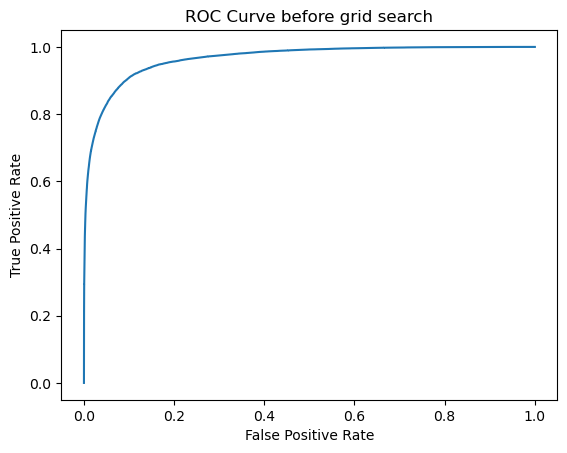

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve before grid search')

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc}")


# Model training with sample dataset
will be taking 200k rows of data which includes all the fruad data from the original dataset and the remaining are randomly chosen non-fraud data

In [57]:
fraudulent_df = merged_df[merged_df['flag'] == 1]
non_fraudulent_df =  merged_df[merged_df['flag'] == 0]

# Calculate how many non-fraudulent transactions you need to sample
num_to_sample = 1000000 - len(fraudulent_df)

# Check if you have enough non-fraudulent transactions
if num_to_sample > len(non_fraudulent_df):
    print("Not enough non-fraudulent transactions to sample from!")
elif num_to_sample <= 0:
    # If you already have 200k or more fraudulent transactions
    sampled_df = fraudulent_df.sample(n=200000, random_state=1)
else:
    # Randomly sample non-fraudulent transactions
    sampled_non_fraudulent_df = non_fraudulent_df.sample(n=num_to_sample, random_state=1)  # Setting random state for reproducibility

    # Concatenate the fraudulent transactions with the sampled non-fraudulent transactions
    sampled_df = pd.concat([fraudulent_df, sampled_non_fraudulent_df])

    # Shuffle the dataset to mix fraudulent and non-fraudulent transactions
    sampled_df = sampled_df.sample(frac=1, random_state=1).reset_index(drop=True)
    print(sampled_df)



        flag   timestamp        amount  gasUsed
0          1  1645484754  1.000000e+16    21000
1          0  1676256179  0.000000e+00   194886
2          0  1625833161  0.000000e+00    46563
3          0  1657417064  0.000000e+00    33448
4          0  1630377260  0.000000e+00    53742
...      ...         ...           ...      ...
999995     0  1630282748  1.296500e+18    21000
999996     0  1496386717  0.000000e+00    74574
999997     0  1645293878  0.000000e+00    46263
999998     0  1643661616  0.000000e+00    46109
999999     1  1536894210  0.000000e+00    38799

[1000000 rows x 4 columns]


In [59]:
X = sampled_df.drop(['flag'], axis=1)
y = sampled_df['flag']
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X, y, test_size=0.3, random_state=101)
X_train_sampled.shape, X_test_sampled.shape, y_train_sampled.shape, y_test_sampled.shape

((700000, 3), (300000, 3), (700000,), (300000,))

In [60]:
# xgboost with sampled dataset
# Define the XGBoost model
xgb_model_s = XGBClassifier(objective='binary:logistic', random_state=1)

# Fit the model to the training data
xgb_model_s .fit(X_train_sampled, y_train_sampled)

# Make predictions on the test data
y_pred = xgb_model_s .predict(X_test_sampled)

accuracy = accuracy_score(y_test_sampled, y_pred)
f1 = f1_score(y_test_sampled, y_pred)
precision = precision_score(y_test_sampled, y_pred)
recall = recall_score(y_test_sampled, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(classification_report(y_test_sampled, y_pred))

Accuracy: 0.90877
F1 score: 0.8718397774791268
Precision: 0.8790225109533162
Recall: 0.8647734767624409
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    192351
           1       0.88      0.86      0.87    107649

    accuracy                           0.91    300000
   macro avg       0.90      0.90      0.90    300000
weighted avg       0.91      0.91      0.91    300000



ROC AUC score: 0.9668677284573289


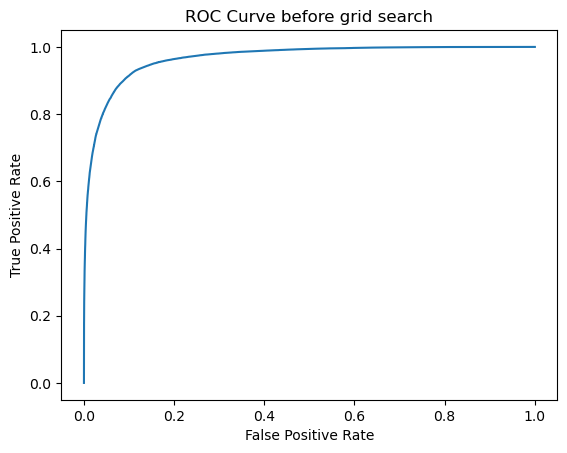

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb_model_s.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve before grid search')

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc}")


# Sampling and non sampling shows different results

`non sampled`
Accuracy: 0.965486087911039 <br>
F1 score: 0.6994643161407489 <br>
Precision: 0.8629688877950737 <br>
Recall: 0.5880482708984061 <br>
ROC AUC: 0.965632460076272 <br>

`sampled`
Accuracy: 0.90877 <br>
F1 score: 0.8718397774791268 <br>
Precision: 0.8790225109533162 <br>
Recall: 0.8647734767624409 <br>
ROC AUC score: 0.9668677284573289 <br>

## conclusion, 
accuracy is worse for sampled data, but the f1 score is better for sampled data, precision, recall and roc auc

will be proceeding to tune the model based on the sampled dataset

In [63]:
# training xgboost with grid search, finding best parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
# Define the XGBoost model
xgb_model_tune = XGBClassifier(objective='binary:logistic', random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model_tune, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_sampled, y_train_sampled)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  34.0s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  34.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  34.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  34.6s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  34.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 1.2min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 1.2min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  52.8s
[CV] END ..learning_rate=0.01, max_depth=4, n_e

In [ ]:
# Define the XGBoost model with the best parameters
xgb_model_tuned = XGBClassifier(objective='binary:logistic', random_state=1)
xgb_model_tuned.set_params(**grid_search.best_params_)

# Fit the model to the training data
xgb_model_tuned.fit(X_train_sampled, y_train_sampled)

# Make predictions on the test data
y_pred = xgb_model_tuned.predict(X_test_sampled)

accuracy = accuracy_score(y_test_sampled, y_pred)
f1 = f1_score(y_test_sampled, y_pred)
precision = precision_score(y_test_sampled, y_pred)
recall = recall_score(y_test_sampled, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred))